In [1]:
"""UMAP Videos"""
import sys
import multiprocessing as mp
from copy import deepcopy
from itertools import product
import numpy as np
import config_dodo
import config
from utilities import read_pickle, write_pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter, find_peaks
from scipy.stats import entropy
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
import plotly.express as px
import plotly.graph_objects as go
import pylab
import scipy.cluster.hierarchy as spc
import scipy.spatial.distance as spd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, filtfilt
from scipy.signal import medfilt
from scipy.stats import trim_mean
import datashader.bundling as bd
from bundle_edges import hammer_connectivity, _get_embedding
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from fastkde import fastKDE
from skimage.filters import gaussian
import statsmodels.api as sm
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde

def density_estimation(m1, m2, bw=1):
    xmin = np.min(m1) - 10
    xmax = np.max(m1) + 5
    ymin = np.min(m2) - 10
    ymax = np.max(m2) + 10
    X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([m1, m2])
    kernel = gaussian_kde(values, bw_method=bw)
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets").mkdir(parents=True, exist_ok=True)
sns.set_context("paper", font_scale=2.0)
sns.set_style(
    "ticks",
    {
        "text.color": "k",
        "axes.edgecolor": "k",
        "axes.labelcolor": "k",
        "xtick.color": "k",
        "ytick.color": "k",
    },
)

/home/alvaro/.local/lib/python3.8/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
wav_sample_path = config_dodo.WAV_PATH / "wav_sample.pickle"
wav_sample = read_pickle(wav_sample_path)
pca_wav_sample_path = config_dodo.WAV_PATH / "pca_wav_sample.pickle"
pca_wav_sample = read_pickle(pca_wav_sample_path)
emb_wav_path = config_dodo.EMB_PATH / "emb_wav_sample.pickle"
emb_wav = read_pickle(emb_wav_path)
out_wav_path = config_dodo.OUT_PATH / "out_wav_sample.pickle"
out_wav = read_pickle(out_wav_path)
knn_wav_path = config_dodo.EMB_PATH / "knn_fit_wav.pickle"
knn_wav = read_pickle(knn_wav_path)
edg_wav_path = config_dodo.EMB_PATH / "edg_wav_sample.pickle"
edg_wav = read_pickle(edg_wav_path)
loc_dim_wav_path = config_dodo.EMB_PATH / "loc_dim_wav_sample.pickle"
loc_dim_wav = read_pickle(loc_dim_wav_path)
out_wav_all = read_pickle(config_dodo.OUT_PATH / "out_wav_all.pickle")
label_wav_all = read_pickle(config_dodo.LAB_PATH / "lab_wav_all.pickle")
label_stp_all = read_pickle(config_dodo.LAB_PATH / "lab_stp_all.pickle")

stp_sample_path = config_dodo.STP_PATH / "stp_sample.pickle"
stp_sample = read_pickle(stp_sample_path)
emb_stp_path = config_dodo.EMB_PATH / "emb_stp_sample.pickle"
emb_stp = read_pickle(emb_stp_path)
out_stp_path = config_dodo.OUT_PATH / "out_stp_sample.pickle"
out_stp = read_pickle(out_stp_path)
knn_stp_path = config_dodo.EMB_PATH / "knn_fit_stp.pickle"
knn_stp = read_pickle(knn_stp_path)
edg_stp_path = config_dodo.EMB_PATH / "edg_stp_sample.pickle"
edg_stp = read_pickle(edg_stp_path)
loc_dim_stp_path = config_dodo.EMB_PATH / "loc_dim_stp_sample.pickle"
loc_dim_stp = read_pickle(loc_dim_stp_path)
out_stp_all = read_pickle(config_dodo.OUT_PATH / "out_stp_all.pickle")
label_stp_all = read_pickle(config_dodo.LAB_PATH / "lab_stp_all.pickle")
label_wav_all = read_pickle(config_dodo.LAB_PATH / "lab_wav_all.pickle")

Sun Feb 13 11:56:46 2022 Building and compiling search function
Sun Feb 13 11:56:53 2022 Building and compiling search function


In [3]:
sample_idx_stp = []
sample_idx_wav = []
lat_sum = 0
for key in config_dodo.KEY_LIST:
    name = config_dodo.SUBJECT_NAME.format(*key)
    pickle_end = name + ".pickle"
    idx = read_pickle(config_dodo.IDX_PATH / f"idx_{pickle_end}")
    sample_idx_stp.append(idx + lat_sum)
    sample_idx_wav.append(idx[::config.EMB_WAV_SUBSAMPLE_EVERY] + lat_sum)
    lat = read_pickle(config_dodo.MTR_PATH / f"Latency/latency_{pickle_end}")
    lat_sum += lat
sample_idx_stp = np.concatenate(sample_idx_stp)
sample_idx_wav = np.concatenate(sample_idx_wav)
sample_stp_in_wav = np.isin(sample_idx_stp, sample_idx_wav, assume_unique=True)
long_data = read_pickle(config_dodo.LAB_PATH / "label_long_data.pickle")
group_to_label_wav = {group: label for group, label in long_data[["sequence_group_wav", "label_wav"]].values}
group_to_label_wav
next_group_wav = long_data.iloc[sample_idx_wav]["sequence_group_wav"] + 1
next_group_wav_label = next_group_wav.map(group_to_label_wav).fillna(method="bfill").fillna(method="ffill").to_numpy()
previous_group_wav = long_data.iloc[sample_idx_wav]["sequence_group_wav"] - 1
previous_group_wav_label = previous_group_wav.map(group_to_label_wav).fillna(method="bfill").fillna(method="ffill").to_numpy()
seq_data_wav = read_pickle(config_dodo.LAB_PATH / "label_sequence_data_wav.pickle")
seq_idx_wav = long_data.iloc[sample_idx_wav]["sequence_group_wav"].to_numpy() - 1
duration_wav = seq_data_wav.iloc[seq_idx_wav]["duration"].to_numpy() * 0.01

In [4]:
m, d, t = (297, 5, 2)
name = config_dodo.SUBJECT_NAME.format(m, d, t)
pickle_end = name + ".pickle"
path_qnt = config_dodo.QNT_PATH / f"qnt_xy_{pickle_end}"
xys = read_pickle(path_qnt)
path_events = config_dodo.MTR_PATH / f"Step/step_events_{pickle_end}"
step_events = read_pickle(path_events)
path_statistics = config_dodo.MTR_PATH / f"Step/step_statistics_{pickle_end}"
step_statistics = read_pickle(path_statistics)
path_latency = config_dodo.MTR_PATH / f"Latency/latency_{pickle_end}"
latency = read_pickle(path_latency)
path_stp = config_dodo.STP_PATH / f"stp_{pickle_end}"
stp = read_pickle(path_stp)
path_stp_scaler = config_dodo.STP_PATH / "standard_scaler_fit_stp.pickle"
stp_scaler = read_pickle(path_stp_scaler)
path_subsample_idx = config_dodo.IDX_PATH / f"idx_{pickle_end}"
subsample_idx = read_pickle(path_subsample_idx)
path_ang = config_dodo.ANG_PATH / f"ang_{pickle_end}"
ang = read_pickle(path_ang)
path_ang_scaler = config_dodo.ANG_PATH / f"standard_scaler_fit_ang.pickle"
ang_scaler = read_pickle(path_ang_scaler)
path_wav = config_dodo.WAV_PATH / f"wav_{pickle_end}"
wav = read_pickle(path_wav)
path_wav_pca = config_dodo.WAV_PATH / "pca_fit_wav.pickle"
wav_pca = read_pickle(path_wav_pca)
path_xys = config_dodo.QNT_PATH / f"qnt_xy_{pickle_end}"
xys = read_pickle(path_xys)[:latency]
path_front_matrix = config_dodo.MED_PATH / f"perspective_{name}C1.pickle"
front_matrix = read_pickle(path_front_matrix)
path_back_matrix = config_dodo.MED_PATH / f"perspective_{name}C2.pickle"
back_matrix = read_pickle(path_back_matrix)

/tmp/ipykernel_3493/20184454.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[-1].set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(axs[-1].get_xticks() * 0.01))


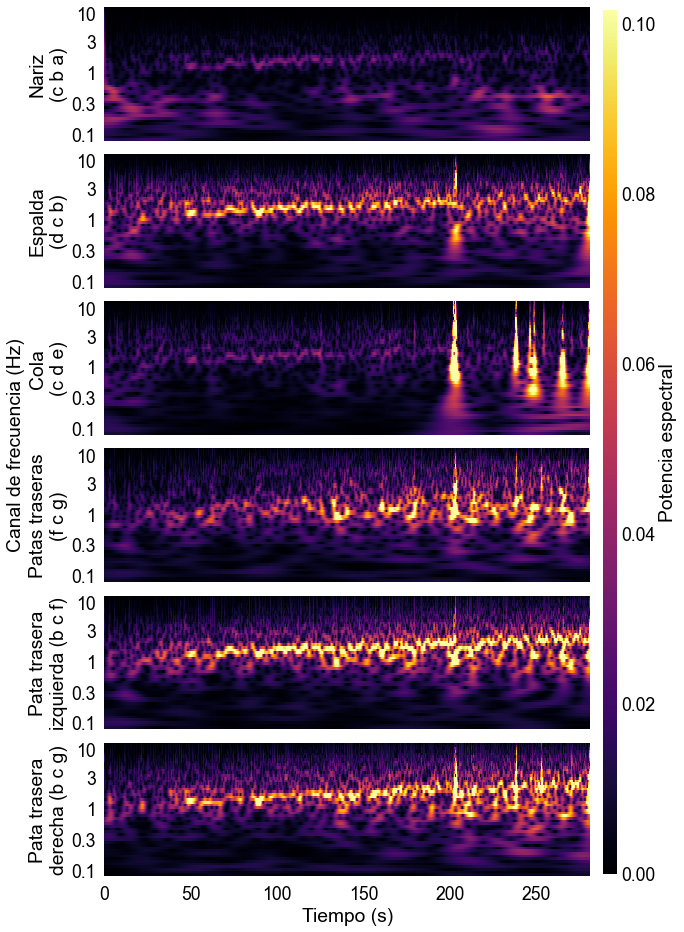

In [5]:
cmap = "inferno"
ANG_MARKER_IDX = [
    [4, 17, 0],  # left hindpaw
    [17, 0, 4],  # left hindpaw
    [4, 17, 1],  # right hindpaw
    [17, 1, 4],  # right hindpaw
    [0, 17, 1],  # cm hindpaws
    [17, 2, 3],  # tail
    [2, 17, 4],  # back
    [17, 4, 2],  # back
    [4, 16, 17],  # nose
    [17, 4, 16],  # nose
]
idxs = [9, 7, 5, 4, 0, 2]
noms = ["Nariz\n(c b a)", "Espalda\n(d c b)", "Cola\n(c d e)", "Patas traseras\n(f c g)", "Pata trasera\nizquierda (b c f)", "Pata trasera\nderecha (b c g)"]
vmin = 0
vmax = np.quantile(wav, 0.99)
fig, axs = plt.subplots(len(idxs), 1, figsize=(10, 16), sharex=True)
for i, ax in enumerate(axs):
    im = ax.imshow(
        wav[:, idxs[i] * config.WAV_NUM_CHANNELS: (idxs[i] + 1) * config.WAV_NUM_CHANNELS].T,
        aspect="auto", origin="lower", cmap=cmap, interpolation="none", vmin=vmin, vmax=vmax,
    )
    ax.set_ylabel(noms[i])
    # ax.set_yticks([0, 12.5, 25, 37.5, 49])
    ax.set_yticks([2, 13.5, 25, 36.5, 47])
    ax.set_yticklabels(["0.1", "0.3", "1", "3", "10"])
    ax.tick_params(bottom=False, left=False)
    ax.set_frame_on(False)
axs[-1].set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(axs[-1].get_xticks() * 0.01))
plt.xlabel("Tiempo (s)")
fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.8175, 0.1275, 0.02, 0.75])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Potencia espectral")
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0)
plt.figtext(-0.01, 0.5, "Canal de frecuencia (Hz)", rotation=90, va="center")
fig.subplots_adjust(hspace=0.1, wspace=0.05)
# plt.savefig(config_dodo.FIG_PATH / "Wavelets" / "espectros_wavelet.pdf", bbox_inches="tight", dpi=600)
# plt.savefig(config_dodo.FIG_PATH / "Wavelets" / "espectros_wavelet.png", bbox_inches="tight", dpi=600)
plt.show()
plt.close()

/tmp/ipykernel_7127/3289700741.py:35: RuntimeWarning: divide by zero encountered in log
  Z = -np.log(Z)
/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


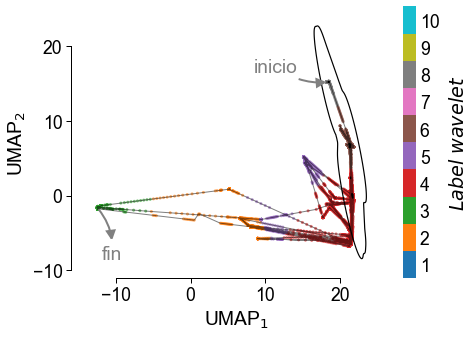

In [65]:
see = long_data.query("mouse == 297 and day == 5 and trial == 2")
color = label_wav_all[see.index]
label = r"$Label$ $wavelet$"
save_name = "label_serie_mapa_wav_100s"
color_dict = dict(zip(range(1, 11), plt.cm.tab10.colors))
color = np.array(np.vectorize(color_dict.get)(color)).T
plt.figure(figsize=(7, 5))
plt.scatter(*out_wav_all[see.index].T, c=color, s=5, alpha=0.5)
plt.plot(*out_wav_all[see.index].T, c="k", alpha=0.5, lw=1)
xy = out_wav_all[see.index[0]]
plt.annotate(
    "inicio", xy=xy, xytext=xy + (-7, 2), ha="center", va="center", color="0.5",
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", color="0.5", lw=2, joinstyle="miter", capstyle="butt")
)
xy = out_wav_all[see.index[-1]]
plt.annotate(
    "fin", xy=xy, xytext=xy + (2, -5), ha="center", va="top", color="0.5",
    arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.2", color="0.5", lw=2, joinstyle="miter", capstyle="butt")
)
X, Y, Z = density_estimation(*out_wav_all[see.index][:10000].T, bw=0.05)
Z = -np.log(Z)
plt.contour(X, Y, Z, levels=1, colors="k")
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(color)
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=10)
cbar.set_ticks(range(1, 11))
cbar.set_ticklabels(range(1, 11))
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
plt.xlim(config.WAT_EMB_WAV_MAIN)
plt.ylim(config.WAT_EMB_WAV_MAIN)
plt.axis("equal")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".pdf"), bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".png"), bbox_inches="tight", dpi=150)
plt.show()
plt.close()

/tmp/ipykernel_7127/958297597.py:21: RuntimeWarning: divide by zero encountered in log
  Z = -np.log(Z)
/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


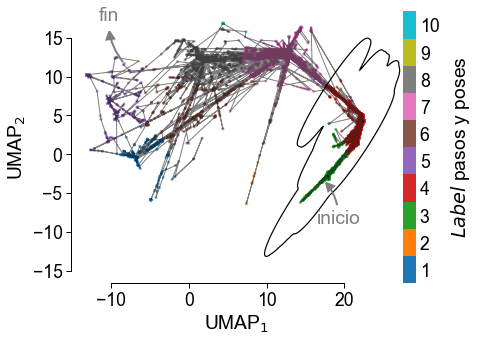

In [66]:
see = long_data.query("mouse == 297 and day == 5 and trial == 2")
color = label_stp_all[see.index]
label = r"$Label$ pasos y poses"
save_name = "label_serie_mapa_stp_100s"
color_dict = dict(zip(range(1, 11), plt.cm.tab10.colors))
color = np.array(np.vectorize(color_dict.get)(color)).T
plt.figure(figsize=(7, 5))
plt.scatter(*out_stp_all[see.index].T, c=color, s=5, alpha=0.5)
plt.plot(*out_stp_all[see.index].T, c="k", alpha=0.5, lw=1)
xy = out_stp_all[see.index[0]]
plt.annotate(
    "inicio", xy=xy, xytext=xy + (2, -5), ha="center", va="center", color="0.5",
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.2", color="0.5", lw=2, joinstyle="miter", capstyle="butt")
)
xy = out_stp_all[see.index[-1]]
plt.annotate(
    "fin", xy=xy, xytext=xy + (-2, 5), ha="center", va="bottom", color="0.5",
    arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.2", color="0.5", lw=2, joinstyle="miter", capstyle="butt")
)
X, Y, Z = density_estimation(*out_stp_all[see.index][:10000].T, bw=0.09)
Z = -np.log(Z)
plt.contour(X, Y, Z, levels=1, colors="k")
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(color)
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=10)
cbar.set_ticks(range(1, 11))
cbar.set_ticklabels(range(1, 11))
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
plt.xlim(config.WAT_EMB_STP_MAIN)
plt.ylim(config.WAT_EMB_STP_MAIN)
plt.axis("equal")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".pdf"), bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".png"), bbox_inches="tight", dpi=150)
plt.show()
plt.close()

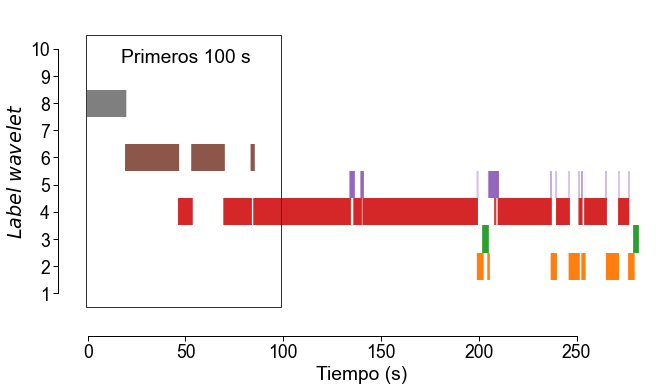

In [81]:
see = long_data.query("mouse == 297 and day == 5 and trial == 2")
ls = label_wav_all[see.index]
save_name = "label_secuencia_wav_100s"
evs = [np.where(ls==l)[0] for l in range(1, 11)]
factor = 1.1 * 1.1
plt.figure(figsize=(9 * factor, 5 * factor))
plt.eventplot(evs, colors=cm.tab10(np.linspace(0, 1, 10)), lw=0.1)
ax = plt.gca()
rect = Rectangle((-100, -0.5), 10000, 10, fc="none", ec="k", zorder=20)
ax.add_patch(rect)
plt.text(5000, 9, "Primeros 100 s", ha="center", va="top")
plt.gca().set_yticks(range(10))
plt.gca().set_yticklabels(range(1, 11))
plt.ylabel(r"$Label$ $wavelet$")
plt.xlabel("Tiempo (s)")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.gca().set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(plt.gca().get_xticks() * 0.01))
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".pdf"), bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".png"), bbox_inches="tight", dpi=150)
plt.show()
plt.close()

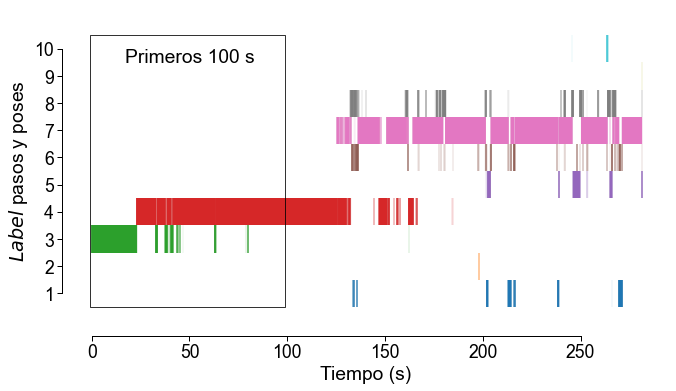

In [83]:
see = long_data.query("mouse == 297 and day == 5 and trial == 2")
ls = label_stp_all[see.index]
save_name = "label_secuencia_stp_100s"
evs = [np.where(ls==l)[0] for l in range(1, 11)]
factor = 1.1 * 1.1
plt.figure(figsize=(9 * factor, 5 * factor))
plt.eventplot(evs, colors=cm.tab10(np.linspace(0, 1, 10)), lw=0.1)
ax = plt.gca()
rect = Rectangle((-100, -0.5), 10000, 10, fc="none", ec="k", zorder=20)
ax.add_patch(rect)
plt.text(5000, 9, "Primeros 100 s", ha="center", va="top")
plt.gca().set_yticks(range(10))
plt.gca().set_yticklabels(range(1, 11))
plt.ylabel(r"$Label$ pasos y poses")
plt.xlabel("Tiempo (s)")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.gca().set_xticklabels(np.vectorize(lambda x: f"{x:.0f}")(plt.gca().get_xticks() * 0.01))
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".pdf"), bbox_inches="tight", dpi=600)
plt.savefig(config_dodo.FIG_PATH / "Transitions" / (save_name + ".png"), bbox_inches="tight", dpi=150)
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/seaborn/utils.py:317: UserWarning: Use the colorbar set_ticks() method instead.
  ax_i.set_yticks(newticks)


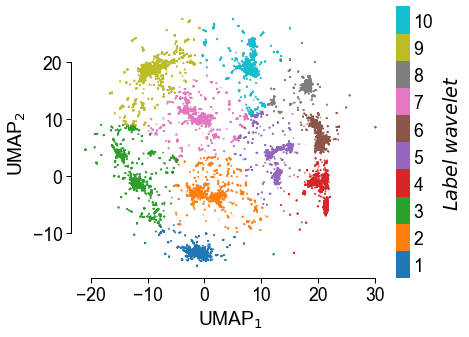

In [8]:
color = label_wav_all[sample_idx_wav]
label = r"$Label$ $wavelet$"
save_name = "label_wav.png"
# color = label_stp_all[sample_idx_wav]
# label = r"$Label$ pasos y poses"
# save_name = "label_contra_wav.png"
# color = next_group_wav_label
# label = r"$Label$ siguiente en la secuencia"
# save_name = "siguiente_label_wav.png"
# color = previous_group_wav_label
# label = r"$Label$ anterior en la secuencia"
# save_name = "label_anterior_wav.png"
plt.figure(figsize=(7, 5))
plt.scatter(*out_wav.T, c=color, cmap="tab10", s=1, alpha=0.1)
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(color)
cbar = plt.colorbar(mappable, ax=plt.gca(), pad=0.0)
cbar.set_label(label=label, labelpad=10)
cbar.set_ticks(range(1, 11))
cbar.set_ticklabels(range(1, 11))
cbar.ax.set_frame_on(False)
cbar.ax.tick_params(axis="both", which="both", length=0)
plt.xlabel(r"UMAP$_1$")
plt.ylabel(r"UMAP$_2$")
sns.despine(trim=True)
plt.gca().tick_params(bottom=True, left=True)
plt.axis("scaled")
# plt.savefig(config_dodo.FIG_PATH / "Embeddings/Colors/Wavelets" / save_name, bbox_inches="tight", dpi=600)
plt.show()
plt.close()

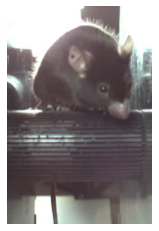

In [44]:
from PIL import Image

frame = 0
path = config_dodo.VID_PATH / f"M{m}D{d}T{t}C1" / f"video-frame{frame + 1:05d}.png"
img = Image.open(path)

width, height = img.size
left = int(0.25 * width)
right = int(0.75 * width)
bottom = 0
top = height
im1 = img.crop((left, bottom, right, top))
plt.imshow(im1)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.axis("off")
plt.show()

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from PIL import Image
from matplotlib.patches import Rectangle

fig, axs = plt.subplot_mosaic(
    [
        ["a", "f1", "b1", "b", "stp", "stp", "stp", "stp"],
        ["wav", "wav", "wav", "wav", "stp", "stp", "stp", "stp"],
        ["wav", "wav", "wav", "wav", "c", "f2", "b2", "d"]
    ],  figsize=(13.65, 7))
for ax in axs.values():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
axs["wav"].scatter(*out_wav[::20].T, c="0.85", s=5, alpha=0.125)
axs["wav"].axis("equal")
axs["stp"].scatter(*out_stp[::40].T, c="0.85", s=5, alpha=0.25)
axs["stp"].axis("equal")
see = long_data.query("mouse == 297 and day == 5 and trial == 2")
label_wav = label_wav_all[see.index]
color_wav_dict = dict(zip(range(1, 11), plt.cm.tab10.colors))
color_wav = np.array(np.vectorize(color_wav_dict.get)(label_wav)).T
label_stp = label_stp_all[see.index]
color_stp_dict = dict(zip(range(1, 11), plt.cm.tab10.colors))
color_stp = np.array(np.vectorize(color_stp_dict.get)(label_stp)).T
# norm = Normalize(vmin=0.5, vmax=10.5)
# mappable = ScalarMappable(norm=norm, cmap="tab10")
# mappable.set_array(range(1, 11))
# cbar_label_wav = r"$Label$ $wavelet$"
# cbar_wav = plt.colorbar(mappable, ax=axs["wav"], pad=0.0)
# cbar_wav.set_label(label=cbar_label_wav, labelpad=10)
# cbar_wav.set_ticks(range(1, 11))
# cbar_wav.set_ticklabels(range(1, 11))
# cbar_wav.ax.set_frame_on(False)
# cbar_wav.ax.tick_params(axis="both", which="both", length=0)
# cbar_label_stp = r"$Label$ pasos y poses"
# cbar_stp = plt.colorbar(mappable, ax=axs["stp"], pad=0.0)
# cbar_stp.set_label(label=cbar_label_stp, labelpad=10)
# cbar_stp.set_ticks(range(1, 11))
# cbar_stp.set_ticklabels(range(1, 11))
# cbar_stp.ax.set_frame_on(False)
# cbar_stp.ax.tick_params(axis="both", which="both", length=0)
# rect_wav = Rectangle((1, 0.55), 8.5, 1, fc="none", ec="k", lw=2, zorder=20)
# cbar_wav.ax.add_patch(rect_wav)
# rect_stp = Rectangle((1, 0.55), 8.5, 1, fc="none", ec="k", lw=2, zorder=20)
# cbar_stp.ax.add_patch(rect_stp)
plt.subplots_adjust(left=-0.01, bottom=0, right=0.98, top=1, wspace=-0.6, hspace=0.1)

def update(frame1, frame2):
    for frame, ax_front, ax_back, (a, b), color in zip(
            (frame1, frame2), (axs["f1"], axs["f2"]), (axs["b1"], axs["b2"]),
            [(0.225, 0.925), (0.1, 0.8)], ("darkseagreen", "slategrey"), #("purple", "orange")
        ):
        path_front = config_dodo.VID_PATH / f"M{m}D{d}T{t}C1" / f"video-frame{frame + 1:05d}.png"
        img_front = Image.open(path_front)
        width, height = img_front.size
        left = int(0.25 * width)
        right = int(0.6 * width)
        bottom = int(a * height)
        top = int((b + 0.05) * height)
        img_front = img_front.crop((left, bottom, right, top))
        im_front = ax_front.imshow(img_front)
        path_back = config_dodo.VID_PATH / f"M{m}D{d}T{t}C2" / f"video-frame{frame + 1:05d}.png"
        img_back = Image.open(path_back)
        width, height = img_back.size
        left = int(0.35 * width)
        right = int(0.68 * width)
        bottom = int(a * height)
        top = int(b * height)
        img_back = img_back.crop((left, bottom, right, top))
        im_back = ax_back.imshow(img_back)
        scatter_wav = axs["wav"].scatter(*out_wav_all[see.index][frame], color=color, s=50, zorder=15)
        circle_wav, = axs["wav"].plot(*out_wav_all[see.index][frame], marker="o", markeredgewidth=3.5, markersize=15, markerfacecolor="none", markeredgecolor=color, zorder=30)
        scatter_stp = axs["stp"].scatter(*out_stp_all[see.index][frame], color=color, s=50, zorder=15)
        circle_stp, = axs["stp"].plot(*out_stp_all[see.index][frame], marker="o", markeredgewidth=3.5, markersize=15, markerfacecolor="none", markeredgecolor=color, zorder=30)
        rect_wav.set_xy((1, int(label_wav[frame]) - 1 + 0.55))
        rect_stp.set_xy((1, int(label_stp[frame]) - 1 + 0.55))
    return [im_front, im_back, scatter_wav, circle_wav, scatter_stp, circle_stp]

update(28120, 10000)
plt.savefig(config_dodo.FIG_PATH / "Embeddings" / "fotogramas_video_umap.pdf", bbox_inches="tight", dpi=300)
plt.close()


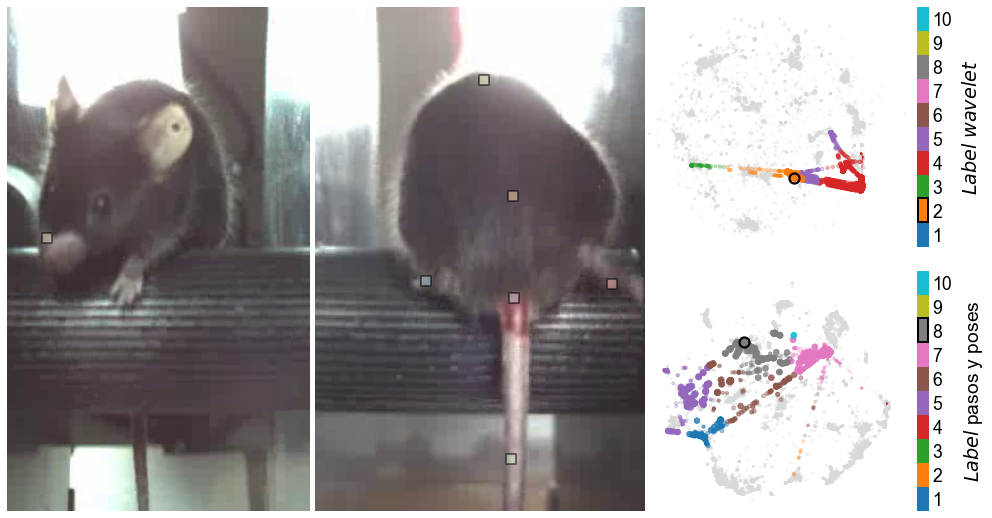

In [293]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle
from cv2 import perspectiveTransform
inv_front_matrix = np.linalg.inv(front_matrix)
inv_back_matrix = np.linalg.inv(back_matrix)
xys_front = perspectiveTransform(xys, inv_front_matrix)
xys_back = perspectiveTransform(xys, inv_back_matrix)

fig, axs = plt.subplot_mosaic(
    [["front", "back", "wav"], ["front", "back", "stp"]],  figsize=(13.65, 7))
for ax in axs.values():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
axs["wav"].scatter(*out_wav[::20].T, c="0.85", s=5, alpha=0.125)
axs["wav"].axis("equal")
axs["stp"].scatter(*out_stp[::40].T, c="0.85", s=5, alpha=0.25)
axs["stp"].axis("equal")
color_markers = plt.cm.Pastel1(np.linspace(0, 1, 9))[:7][::-1]
see = long_data.query("mouse == 297 and day == 5 and trial == 2")
trail = 10000
alphas = np.linspace(0, 1, trail + 1) ** 2
sizes = np.linspace(0, 1, trail + 1) ** 2 * 40
label_wav = label_wav_all[see.index]
color_wav_dict = dict(zip(range(1, 11), plt.cm.tab10.colors))
color_wav = np.array(np.vectorize(color_wav_dict.get)(label_wav)).T
circle_wav, = axs["wav"].plot([], [], "ko", markeredgewidth=2.25, markersize=10, markerfacecolor="none", markeredgecolor="k", zorder=30)
label_stp = label_stp_all[see.index]
color_stp_dict = dict(zip(range(1, 11), plt.cm.tab10.colors))
color_stp = np.array(np.vectorize(color_stp_dict.get)(label_stp)).T
circle_stp, = axs["stp"].plot([], [], "ko", markeredgewidth=2.25, markersize=10, markerfacecolor="none", markeredgecolor="k", zorder=30)
norm = Normalize(vmin=0.5, vmax=10.5)
mappable = ScalarMappable(norm=norm, cmap="tab10")
mappable.set_array(range(1, 11))
cbar_label_wav = r"$Label$ $wavelet$"
cbar_wav = plt.colorbar(mappable, ax=axs["wav"], pad=0.0)
cbar_wav.set_label(label=cbar_label_wav, labelpad=10)
cbar_wav.set_ticks(range(1, 11))
cbar_wav.set_ticklabels(range(1, 11))
cbar_wav.ax.set_frame_on(False)
cbar_wav.ax.tick_params(axis="both", which="both", length=0)
cbar_label_stp = r"$Label$ pasos y poses"
cbar_stp = plt.colorbar(mappable, ax=axs["stp"], pad=0.0)
cbar_stp.set_label(label=cbar_label_stp, labelpad=10)
cbar_stp.set_ticks(range(1, 11))
cbar_stp.set_ticklabels(range(1, 11))
cbar_stp.ax.set_frame_on(False)
cbar_stp.ax.tick_params(axis="both", which="both", length=0)
rect_wav = Rectangle((1, 0.55), 8.5, 1, fc="none", ec="k", lw=2, zorder=20)
cbar_wav.ax.add_patch(rect_wav)
rect_stp = Rectangle((1, 0.55), 8.5, 1, fc="none", ec="k", lw=2, zorder=20)
cbar_stp.ax.add_patch(rect_stp)
plt.subplots_adjust(left=-0.01, bottom=0, right=0.98, top=1, wspace=-0.025, hspace=0.1)

def update(frame):
    path_front = config_dodo.VID_PATH / f"M{m}D{d}T{t}C1" / f"video-frame{frame + 1:05d}.png"
    img_front = Image.open(path_front)
    width, height = img_front.size
    left = int(0.25 * width)
    right = int(0.7 * width)
    bottom = 0
    top = height
    img_front = img_front.crop((left, bottom, right, top))
    im_front = axs["front"].imshow(img_front)
    axs["front"].scatter(
        *(xys_front[frame, [16]] - (left, bottom)).T,
        color=color_markers[0], s=100, linewidths=2, marker="s", edgecolors="k", alpha=0.5, zorder=15
    )
    path_back = config_dodo.VID_PATH / f"M{m}D{d}T{t}C2" / f"video-frame{frame + 1:05d}.png"
    img_back = Image.open(path_back)
    width, height = img_back.size
    left = int(0.275 * width)
    right = int(0.68 * width)
    bottom = 0.075 * height
    top = 0.9 * height
    img_back = img_back.crop((left, bottom, right, top))
    im_back = axs["back"].imshow(img_back)
    axs["back"].scatter(
        *(xys_back[frame, [4, 17, 2, 3, 0, 1]] - (left, bottom)).T,
        color=color_markers[1:], s=100, linewidths=2, marker="s", edgecolors="k", alpha=0.5, zorder=15
    )
    scatter_wav = axs["wav"].scatter(*out_wav_all[see.index][np.maximum(0, frame - trail):frame + 1].T, c=np.column_stack(
        (color_wav[np.maximum(0, frame - trail):frame + 1], alphas[-np.minimum(frame, trail) - 1:])
    ), s=sizes[-np.minimum(frame, trail) - 1:], zorder=15)
    circle_wav.set_data(*out_wav_all[see.index][frame])
    scatter_stp = axs["stp"].scatter(*out_stp_all[see.index][np.maximum(0, frame - trail):frame + 1].T, c=np.column_stack(
        (color_stp[np.maximum(0, frame - trail):frame + 1], alphas[-np.minimum(frame, trail) - 1:])
    ), s=sizes[-np.minimum(frame, trail) - 1:], zorder=15)
    circle_stp.set_data(*out_stp_all[see.index][frame])
    rect_wav.set_xy((1, int(label_wav[frame]) - 1 + 0.55))
    rect_stp.set_xy((1, int(label_stp[frame]) - 1 + 0.55))
    return [im_front, im_back, scatter_wav, circle_wav, scatter_stp, circle_stp]

# update(5000)
# update(15000)
update(25000)

(config_dodo.VID_PATH / f"M{m}D{d}T{t}").mkdir(parents=True, exist_ok=True)
# for frame in range(0, len(see), 10000):
# for frame in range(0, 100):
# for frame in range(100, 200, 4):
#     update(frame)
#     path_save = config_dodo.VID_PATH / f"M{m}D{d}T{t}" / f"video-frame{frame + 1:05d}.png"
#     plt.savefig(path_save, dpi=100)

# ani = FuncAnimation(
#     fig, update, frames=range(0, len(see), 10000), blit=True
# )
# writer = FFMpegWriter(fps=1)
# ani.save("test_mouse.mp4", writer=writer, dpi=100)